# Analyze A/B Test Results 

- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)

<a id='probability'></a>
## Part I - Probability

In [39]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline

random.seed(42)


<center>

|Data columns|Purpose|Valid values|
| ------------- |:-------------| -----:|
|user_id|Unique ID|Int64 values|
|timestamp|Time stamp when the user visited the webpage|-|
|group|In the current A/B experiment, the users are categorized into two broad groups. <br>The `control` group users are expected to be served with `old_page`; and `treatment` group users are matched with the `new_page`. <br>However, **some inaccurate rows** are present in the initial data, such as a `control` group user is matched with a `new_page`. |`['control', 'treatment']`|
|landing_page|It denotes whether the user visited the old or new webpage.|`['old_page', 'new_page']`|
|converted|It denotes whether the user decided to pay for the company's product. Here, `1` means yes, the user bought the product.|`[0, 1]`|
</center>

In [40]:
df = pd.read_csv('ab_data.csv')

df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [41]:
# length of rows in df
rows = len(df)

print(rows)

294478


In [42]:
# number of unique users in dataset
df.nunique()

user_id         290584
timestamp       294478
group                2
landing_page         2
converted            2
dtype: int64

In [43]:
# proportion of users who converted
users_converted = len(df.query('converted == 1')) / rows

print(users_converted)

0.11965919355605512


In [44]:
# number of times when group doesnt match with correct page
x = len(df.query('group == "treatment" & landing_page == "old_page"'))

print(x)

1965


In [46]:
# Remove the inaccurate rows, and store the result in a new dataframe df2
df2 = df[((df['group'] == 'treatment') & (df['landing_page'] == 'new_page')) |
         ((df['group'] == 'control') & (df['landing_page'] == 'old_page'))].copy()

df = df[~(((df['group'] == 'treatment') & (df['landing_page'] != 'new_page')) |
          ((df['group'] == 'control') & (df['landing_page'] != 'old_page')))]

In [47]:
# checking that all incorrect rows were removed
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

In [48]:
# number of unique users in new df
df2.nunique()

user_id         290584
timestamp       290585
group                2
landing_page         2
converted            2
dtype: int64

In [49]:
# finding repeated user in df2
repeated_user_id = df2[df2.duplicated(subset='user_id')]['user_id'].values[0]

print(repeated_user_id)

773192


In [50]:
# displaying duplicated rows
duplicate_rows = df2[df2.duplicated(subset='user_id', keep=False)]

print(duplicate_rows)

      user_id                   timestamp      group landing_page  converted
1899   773192  2017-01-09 05:37:58.781806  treatment     new_page          0
2893   773192  2017-01-14 02:55:59.590927  treatment     new_page          0


In [51]:
# Removing one of the rows with a duplicate user_id

df2 = df2.drop_duplicates(subset='user_id', keep='first')

# double checking that the duplicated row was removed
print(sum(df2.duplicated()))

0


In [52]:
# probability of user converting regardless of page
ppopulation = len(df2.query('converted == 1')) / len(df2)

print(ppopulation)

0.11959708724499628


In [53]:
# probability of user in control group converting
pconverted = len(df2.query('group == "control" & converted == 1')) / len(df2.query('group == "control"'))

print(pconverted)

0.1203863045004612


In [54]:
# probability that user in treatment group converted
ptreatment = len(df2.query('group == "treatment" & converted == 1')) / len(df2.query('group == "treatment"'))

print(ptreatment)

0.11880806551510564


In [55]:
# calculating observed difference between conversion rates for new page and old page
obs_diff = ptreatment - pconverted

print(obs_diff)

-0.0015782389853555567


In [56]:
# probability that an individual receives the new page
pnewpage = len(df2.query('landing_page == "new_page"')) / len(df2)

print(pnewpage)

0.5000619442226688


### Conclusion

From the observed data, the new page does not lead to more conversions than the old page as the conversion rate for the new page was 0.0015 less than for the control group.

<a id='ab_test'></a>
## Part II - A/B Test

$H_{0}$: $p_{new}$ <= $p_{old}$

$H_{1}$: $p_{new}$ > $p_{old}$


In [57]:
# conversion rate for Pnew under null hypothesis
pnew = ppopulation

print(pnew)

0.11959708724499628


In [58]:
# conversion rate for Pold under null hypothesis
pold = ppopulation

print(pold)

0.11959708724499628


In [60]:
# number of individuals in treatment group
nnew = len(df2.query('landing_page == "new_page"'))

print(nnew)

145310


In [61]:
# number of individuals in control group
nold = len(df2.query('landing_page == "old_page"'))

print(nold)

145274


In [65]:
# Simulating a Sample for the treatment group
new_page_converted = np.random.choice([0,1], size=nnew, p=[pnew, 1-pnew])

print(new_page_converted.mean())

0.879251255935586


In [66]:
# Simulating a Sample for the control group
old_page_converted = np.random.choice([0,1], size=nold, p=[pold, 1-pold])

print(old_page_converted.mean())

0.8793934220851632


In [67]:
# difference in converted probability for simulated samples
print(new_page_converted.mean() - old_page_converted.mean())

-0.00014216614957729412


In [68]:
# Sampling distribution
new_page_converted = np.random.binomial(nnew,pnew,10000)/nnew
old_page_converted = np.random.binomial(nold,pold,10000)/nold
p_diffs = new_page_converted - old_page_converted 

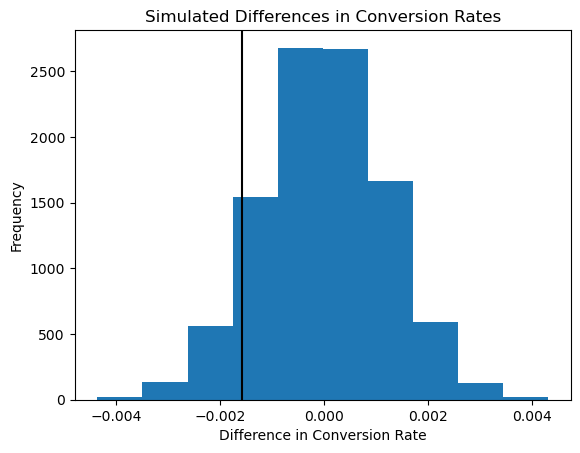

In [69]:
# histogram for simulated differences in conversion rates
plt.hist(p_diffs)
plt.title("Simulated Differences in Conversion Rates")
plt.xlabel("Difference in Conversion Rate")
plt.ylabel("Frequency")
plt.axvline(obs_diff, color="black");

In [70]:
# proportion of simulated differences greater than actual difference
print((p_diffs > obs_diff).mean())

0.9076


This value is the p-value, calculated by finding the proprotion where the simulated difference in conversion rates are greater than the observed difference in conversion rate. The p-value found was 0.9076 which is significantly higher than the Type I error rate of 0.05. This means that the null hypothesis is supported in that the conversion rate for the new page is either equal to or less than the conversion rate for the old page. 

In [71]:
import statsmodels.api as sm

# number of conversions with the old_page
convert_old = len(df2.query('landing_page == "old_page" & converted == 1'))

# number of conversions with the new_page
convert_new = len(df2.query('landing_page == "new_page" & converted == 1'))

# number of individuals who were shown the old_page
n_old = len(df2.query('landing_page == "old_page"'))

# number of individuals who received new_page
n_new = len(df2.query('landing_page == "new_page"'))

In [72]:
# computing z-score and p-value
z_score, p_value = sm.stats.proportions_ztest(np.array([convert_new, convert_old]), np.array([n_new, n_old]), alternative='larger')
print(z_score, p_value)

-1.3109241984234394 0.9050583127590245


Since it is a right-tailed test and the z-score is less than the z-alpha, we fail to reject the null hypothesis. The p-value is also greater than 0.05, so again it supports the conclusion to fail to reject the null hypothesis. Essentially, it means that there is no statistically significant difference between the conversion rates for the old page and new page.

<a id='regression'></a>
### Part III - A regression approach

Logistic regression should be used because the dependent variable, whether an individual converted or not, is binary. 

In [73]:
# creating a constant variable
df2['intercept'] = 1

# creating the predictor variable based on old page or new page
df2['ab_page'] = np.where(df2['group'] == "treatment", 1, 0)

df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


In [74]:
# creating logistic regression model with converted as the dedepdent variable
X = df2[['intercept', 'ab_page']]

Y = df2['converted']

model= sm.Logit(Y, X).fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


In [75]:
# summary of model
print(model.summary())

                           Logit Regression Results                           
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Thu, 22 Feb 2024   Pseudo R-squ.:               8.077e-06
Time:                        19:42:24   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1899
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007


The p-value associated with ab_page is 0.190 which is higher than the p-value found in Part II. It differs because the regression model's null hypothesis is that there is no relationship between page and conversion rate while the alternative hypothesis is that there is a relationship between page and conversion rate. This differs from Part II's null hypothesis which is the probability of conversion given the new page is equal to or less than the probability of conversion given the old page while the alternative hypothesis is the probability of conversion given the new page is greater than the probability of conversion given the old page. These are fundamentally different hypotheses because Part II uses a one-sided hypothesis while Part III uses a two-sided hypothesis. While these p-values are different, the p-value found in Part III still points to failing to reject the null hypothesis, which in this case, is supporting the fact that there is no relationship between page and conversion rate.

It is a good idea to add other factors to the regression model because it has been shown that only using landing page as a predictor does not accurately predict conversion or not. Adding more predictors could strengthen the model by improving the prediction accuracy. It can also show relationships between predictors and conversion rate. There are some disadvantages to adding additional terms to the regression model such as overfitting as well as making it difficult to see the effect of each predictor.

In [76]:
# Reading the countries.csv to add country as a predictor variable
countries = pd.read_csv('countries.csv')

countries.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [77]:
# Join countries with the df2 dataframe
df_merged = pd.merge(df2, countries, on='user_id', how='inner')

df_merged.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US


In [85]:
# Create the dummy variables for country
df_merged[['UK', 'US', 'CA']] = pd.get_dummies(df_merged['country'], dtype=int)

# Drop one of the countries to avoid multicollinearity
df_merged = df_merged.drop('CA', axis=1)

df_merged.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country,UK,US
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US,0,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US,0,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US,0,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US,0,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US,0,0


In [87]:
# creating model

X = df_merged[['intercept', 'ab_page', 'UK', 'US']]
Y = df_merged['converted']

model2 = sm.Logit(Y, X).fit()

print(model2.summary())

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Thu, 22 Feb 2024   Pseudo R-squ.:               2.323e-05
Time:                        19:49:47   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1760
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9893      0.009   -223.763      0.000      -2.007      -1.972
ab_page       -0.0149      0.

The logistic regression results support the conclusion to fail to reject the null hypothesis becuase the p-values for the UK and the US are greater than 0.05. The p-value being greater than 0.05 means that there is no statistically significant difference between the country the user resides in and the conversion rate for the page viewed.

In [88]:
# creating model based on interaction between page and country

df_merged['UK_page'] = df_merged['UK'] * df_merged['ab_page']
df_merged['US_page'] = df_merged['US'] * df_merged['ab_page']

Y = df_merged['converted']
X = df_merged[['intercept', 'ab_page', 'UK', 'US', 'UK_page', 'US_page']]

model = sm.Logit(Y, X).fit()

print(model.summary())

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Thu, 22 Feb 2024   Pseudo R-squ.:               3.482e-05
Time:                        19:55:32   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1920
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9865      0.010   -206.344      0.000      -2.005      -1.968
ab_page       -0.0206      0.

### Conclusion
Overall, the country and page does not affect the conversion rate as the p-values are all greater than 0.05, indicating that there is no statistically significant difference in conversion rate based on which country a user resides in and which page a user views. Based on this, there is a failure to reject to the null hypothesis, which indicates that there is no relationship between country, page, and conversion rate. Neither of those predictor values are accurate in predicting whether a user converts or not. Ultimately, there is no evidence to suggest that the new page is bringing in higher conversion rates based on country. Based on these models, the company should consider keeping the old page for now since there is no evidence of a higher conversion rate with the new page.